In [55]:
# 04_log_prediction

In [56]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [57]:
### IMPORT ###
from pathlib import Path
from datetime import datetime
import pandas as pd
import re
import numpy as np
# plot
import matplotlib.pyplot as plt
# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
# DL
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# XAI
import shap
# Code warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [58]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import extract_files, convert_seconds_to_hours

In [59]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")

dic_types = dict(yaml_config["EVENT_LOG_TYPES"]) 

encoding_dir = str(yaml_config["LOG_ENCODING_DIR"]) # <-- INPUT: the directory with files encoded for the ML models

# ML
ml_dir = str(yaml_config["ML_DIR"]) # <-- INPUT: the directoryin which to save ML results
label_column = "REMAINING_TIME_sec" # <-- INPUT: label for prediction
drop_column = ["CaseID", "TIMESTAMP"]  # <-- INPUT: columns to drop
cv_folds = int(yaml_config["CV_FOLDS"])
ht = 0 # # <-- INPUT performs hypertuning: 1 yes, 0 no 
ht_str = None

# Event log types (stadard or enriched)
std_suffix = str(yaml_config["STD_SUFFIX"])
enr_suffix = str(yaml_config["ENR_SUFFIX"])

# PLOT
plot_dir = str(yaml_config["PLOT_DIR"])



# FUNCTIONS

In [60]:
def plot_custom_distribution(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.title(f'Distribution of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [61]:
def plot_custom_distribution_with_colours(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]
    encoding_values = dataframe[encoding_column]

    # Create a colour map
    colours = encoding_values.map({'B': 'skyblue', 'F': 'lightgreen'})

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color=colours)
    plt_title = f"Distribution of '{y_column}' by '{x_column}'"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='skyblue', lw=4, label='B'),
        plt.Line2D([0], [0], color='lightgreen', lw=4, label='F')
    ], title=encoding_column)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [62]:
def plot_custom_distribution_side_by_side(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str, model_name:str, ht_str:str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    model_name (str): The name of the model used.
    ht_str (str): The model is hypertuned or not.
    """

    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()
    
    # Calculate width for each bar
    bar_width = 0.25  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}' \n Model: {model_name}"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2, unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()

    file_path = f'plots/{model_name}_plot_{ht_str}_HT.png'
    plt.savefig(file_path)

    plt.show()

In [ ]:
def perform_regression_lstm_base(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    target: pd.Series,
    df_log_ml_features: pd.DataFrame,
    file_name: str,
    type: str,
    prefix: str,
    encoding: str,
    cv_folds: int = 5
) -> dict:
    """
    Perform regression using LSTM and evaluate the model with RMSE and MAE.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing LSTM Regression")

    # Reshape for LSTM [samples, time steps, features]
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Costruzione del modello LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Compilazione del modello
    model.compile(optimizer='adam', loss='mse')

    # Addestramento del modello
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

    # Predizione sui dati di test
    y_pred = model.predict(X_test_reshaped)

    # Valutazione
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in seconds before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Prepare reshaped features for cross-validation
    def lstm_cross_val_predictor(X, y, cv_folds):
        """ Cross-validation utility for LSTM."""
        scores_rmse = []
        scores_mae = []
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

        for train_index, test_index in kfold.split(X):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Reshape folds for LSTM input
            X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], 1, X_train_fold.shape[1]))
            X_test_fold = X_test_fold.reshape((X_test_fold.shape[0], 1, X_test_fold.shape[1]))

            # Define model
            model_fold = Sequential()
            model_fold.add(LSTM(units=50, activation='relu', input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])))
            model_fold.add(Dropout(0.2))
            model_fold.add(Dense(1))
            model_fold.compile(optimizer='adam', loss='mse')

            # Train model
            model_fold.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, verbose=0)

            # Evaluate model
            y_pred_fold = model_fold.predict(X_test_fold)
            rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
            mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)

            scores_rmse.append(rmse_fold)
            scores_mae.append(mae_fold)

        return np.array(scores_rmse), np.array(scores_mae)

    # Prepare data for cross-validation
    X_cv = df_log_ml_features.values
    y_cv = target.values

    # Reshape features for LSTM input
    X_cv = X_cv.reshape((X_cv.shape[0], 1, X_cv.shape[1]))

    # Cross-validation scores
    cv_rmse_scores, cv_mae_scores = lstm_cross_val_predictor(X_cv, y_cv, cv_folds)

    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean:.2f}, MAE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
        "Model": "LSTM",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, model

In [ ]:
def perform_regression_dtr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, type:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Decision Tree and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing DTR")
    # Training
    dt_regressor = DecisionTreeRegressor(random_state=42)
    dt_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = dt_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(dt_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(dt_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean:.2f}, MAE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
        "Model": "DTR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, dt_regressor

In [63]:
def perform_regression_rfr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test:pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, type:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing RFR")
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
    "Model": "RFR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, rf_regressor

In [64]:
def perform_regression_xgr_base(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression")

    # Training the model
    xgb_regressor = XGBRegressor(n_estimators=150, random_state=42, verbosity=0)
    xgb_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")

    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m
    }

    return results_dict, xgb_regressor

In [65]:
def perform_regression_rfr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest with hyperparameter optimization using Hyperopt.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics and best hyperparameters.
    """
    print(">> Performing RFR")
    def objective(params):
        rf_regressor = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42
        )
        
        # Scorer define for RMSE (negative since cross_val_score minimizes the score)
        neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

        # Cross-validation to get the negative RMSE
        cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)
        
        # Convert the negative scores to positive for RMSE
        cv_rmse_scores = -cv_scores
        cv_rmse_mean = cv_rmse_scores.mean()
        
        return {'loss': cv_rmse_mean, 'status': STATUS_OK}

    # Define the search space
    space = {
        # 'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 50),
        # 'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'max_depth': hp.quniform('max_depth', 5, 15, 1),
        # 'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_split': hp.quniform('min_samples_split', 4, 8, 1),
        # 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 4, 1)
    }

    # Run the optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

    print("Best hyperparameters found: ", best)

    # Train the model with the best hyperparameters
    rf_regressor = RandomForestRegressor(
        n_estimators=int(best['n_estimators']),
        max_depth=int(best['max_depth']),
        min_samples_split=int(best['min_samples_split']),
        min_samples_leaf=int(best['min_samples_leaf']),
        random_state=42
    )
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds before CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")
    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
        "Model": "RFR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m,
        "Best_Hyperparameters": best  # Added best hyperparameters
    }

    return results_dict, rf_regressor

In [66]:
# HYPEROPT
def perform_regression_xgr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, type:str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost with hyperparameter optimization and evaluate the model with RMSE.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        type (str): Type of the file (std or enr).
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression with Hyperopt")

    # Define the hyperparameter space
    space = {
        #'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        # 'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        # 'subsample': hp.uniform('subsample', 0.5, 1.0),
        'subsample': hp.uniform('subsample', 0.6, 0.9),
        # 'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.8),
        # 'n_estimators': hp.choice('n_estimators', [100, 150, 200, 250, 300])
        'n_estimators': hp.choice('n_estimators', [100, 150, 200])
    }

    # Objective function for Hyperopt
    def objective(params):
        model = XGBRegressor(
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            n_estimators=params['n_estimators'],
            random_state=42,
            verbosity=0
        )
        # Using cross-validation to evaluate the model
        neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
        cv_scores = cross_val_score(model, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)
        return -cv_scores.mean()  # Minimize negative RMSE

    # Optimize hyperparameters
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

    print("Best hyperparameters:", best)

    # Train the final model with best hyperparameters
    xgb_regressor = XGBRegressor(
        max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'],
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        n_estimators=best['n_estimators'],
        random_state=42,
        verbosity=0
    )
    xgb_regressor.fit(X_train, y_train)

    # Test the model
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    # RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # MAE
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE of the model in second before CV:", rmse)
    print("MAE of the model in seconds CV:", mae)

    print("> CV validation")
    print("Folds:", cv_folds)

    # RMSE Cross-validation with best model
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    cv_rmse_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_rmse_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # MAE Cross-validation with best model
    neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # MAE Cross-validation
    cv_mae_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_mae_scorer)

    # Convert negative MAE scores to positive values
    cv_mae_scores = -cv_mae_scores
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()

    # Convert all (MAE and RMSE) seconds to minutes and hours 
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)
    cv_mae_mean_m, cv_mae_mean_h = convert_seconds_to_hours(cv_mae_mean)
    cv_mae_std_m, cv_mae_std_h = convert_seconds_to_hours(cv_mae_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores} \n RMSE mean: {cv_rmse_mean:.2f}, RMSE std: {cv_rmse_std:.2f}")
    print(f"MAE of every fold in seconds: {cv_mae_scores} \n MAE mean: {cv_mae_mean}:.2f, RMSE std: {cv_mae_std:.2f}")
    
    print()

    print(f"Cross-validated RMSE mean: {cv_rmse_mean_m:.2f} minutes, {cv_rmse_mean_h:.2f} hours")
    print(f"Cross-validated RMSE std: {cv_rmse_std_m:.2f} minutes, {cv_rmse_std_h:.2f} hours")

    print(f"Cross-validated MAE mean: {cv_mae_mean_m:.2f} minutes, {cv_mae_mean_h:.2f} hours")
    print(f"Cross-validated MAE std: {cv_mae_std_m:.2f} minutes, {cv_mae_std_h:.2f} hours")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Type": type,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "MAE_Before_CV_s": mae,
        "RMSE_CV_scores_s": cv_rmse_scores.tolist(),
        "RMSE_CV_Mean_s": cv_rmse_mean,
        "RMSE_CV_Std_s": cv_rmse_std,
        "RMSE_CV_Mean_m": cv_rmse_mean_m,
        "RMSE_CV_Std_m": cv_rmse_std_m,
        "MAE_CV_Scores_s": cv_mae_scores.tolist(),
        "MAE_CV_Mean_s": cv_mae_mean,
        "MAE_CV_Std_s": cv_mae_std,
        "MAE_CV_Mean_m": cv_mae_mean_m,
        "MAE_CV_Std_m": cv_mae_std_m,
        "Best_Hyperparameters": {
            "max_depth": int(best['max_depth']),
            "learning_rate": best['learning_rate'],
            "subsample": best['subsample'],
            "colsample_bytree": best['colsample_bytree'],
            "n_estimators": best['n_estimators']
        }
    }

    return results_dict, xgb_regressor

In [67]:
def explain_model_with_shap(model, X_train, X_test):
    # Create a SHAP explainer object
    explainer = shap.Explainer(model, X_train)

    # Calculate SHAP values for the test set
    shap_values = explainer(X_test)

    # Summary plot for global feature importance
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    # Detailed summary plot
    shap.summary_plot(shap_values, X_test)

    # Explanation for a single prediction
    shap.plots.waterfall(shap_values[0])

# MAIN

In [68]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-06 12:56:14



In [69]:
print(">> Creating output directories")
directory_path = Path(ml_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
directory_path = Path(plot_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'plots' created successfully.


In [70]:
print(">> Listing event log prefixes files")
list_files = extract_files(encoding_dir, "csv")
list_files_len = len(list_files)
print("Files found (num):", list_files_len)
print("Files found (list):", list_files)
print()

print("> Splitting standad and enriched")

list_files_std = [file for file in list_files if f'_{std_suffix}_' in file]
list_files_std_len = len(list_files_std)

list_files_enr = [file for file in list_files if f'_{enr_suffix}_' in file]
list_files_enr_len = len(list_files_enr)

print("Files standard found (num):", list_files_std_len)
print("Files standard found (list):", list_files_std)
print("Files enriched found (num):", list_files_enr_len)
print("Files enriched found (list):", list_files_enr)

>> Listing event log prefixes files
Files found (num): 18
Files found (list): ['EVENT-LOG_ED_duration_enr_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_enr_prefix_3h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_std_prefix_3h_I.csv']

> Splitting standad and enriched
Files standard found (num): 9
Files standard found (list): ['EVENT-LOG_ED_dur

In [ ]:
print(">> Hypertuning settings")
if ht == 0:
    ht_str="no"
else:
    ht_str="yes"

In [71]:
list_results_ml = []
print(">> Reading event log prefixes files and applying ML models")
i = 1
for file_name in list_files:
    print(f"[{i} / {list_files_len}]")
    path_data = Path(encoding_dir) / file_name
    print("File:", path_data)

    # Get from the file_name type, prefix length and encoding
    pattern = r'duration_(enr|std)_prefix_(\d+)h_([A-Z])' 
    match = re.search(pattern, file_name)
    type = match.group(1)
    prefix = match.group(2)
    encoding = match.group(3)
    print("Type (std / enr):", type )
    print("Prefix:", prefix)
    print("Encoding:", encoding)

    df_log = pd.read_csv(path_data, sep=";", dtype=dic_types)
    print("Event log shape:", df_log.shape)
    print("Event log cases:", df_log["CaseID"].nunique())
    # print(df_log.columns) # debug

    print("> Removing columns")
    print(drop_column)
    df_log_ml = df_log.drop(drop_column, axis=1)

    print("> Preparing data for regression")
    df_log_ml_features = df_log_ml.drop(columns=['REMAINING_TIME_sec'], axis=1) # Final features as input to the model
    
    # Select the "label"
    target = df_log_ml[label_column]

    # Training and Test split
    X_train, X_test, y_train, y_test = train_test_split(df_log_ml_features, target, test_size=0.2, random_state=42)

    results_dict = None 
    dtr_regressor = None
    rfr_regressor = None
    xgb_regressor = None

    results_dict, dtr_regressor = perform_regression_dtr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    list_results_ml.append(results_dict)
    
    # Performs the function with hypertuning or the basic function
    if ht==1:
        results_dict, rfr_regressor = perform_regression_rfr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    else:
        results_dict, rfr_regressor = perform_regression_rfr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    list_results_ml.append(results_dict)

    # Performs the function with hypertuning or the basic function
    if ht==1:
        results_dict, xgb_regressor = perform_regression_xgr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    else:
        results_dict, xgb_regressor = perform_regression_xgr_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    list_results_ml.append(results_dict)

    results_dict, lstm_regressor = perform_regression_lstm_base(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, type, prefix, encoding, 5)
    list_results_ml.append(results_dict)

    i+=1
    
    print("-"*8)

>> Reading event log prefixes files and applying ML models
[1 / 18]
File: data_encoding/EVENT-LOG_ED_duration_enr_prefix_1h_B.csv
Type (std / enr): enr
Prefix: 1
Encoding: B
Event log shape: (11289, 195)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
100%|██████████| 50/50 [20:18<00:00, 24.37s/trial, best loss: 1137.2366562579032]
Best hyperparameters found:  {'max_depth': 11.0, 'min_samples_leaf': 4.0, 'min_samples_split': 6.0, 'n_estimators': 200.0}
RMSE of the model in second before CV: 675.6297141774107
MAE of the model in seconds before CV: 432.38453916175445
> CV validation
Folds: 5
RMSE of every fold in seconds: [1360.91136806  951.72171393 1252.19348447  988.24540851 1133.11130633] 
 RMSE mean: 1137.24, RMSE std: 154.84
MAE of every fold in seconds: [572.09113516 564.2302985  616.69926836 558.25795595 648.11163206] 
 MAE mean: 591.8780580043858:.2f, RMSE std: 34.83

Cross-validated RMSE mean: 18.95 minutes, 0.3

In [ ]:
print(">> Creating ML results")
df_ml = pd.DataFrame.from_records(list_results_ml)
df_ml = df_ml.sort_values(by = ["File"])
df_ml

>> Creating ML results


,Model,File,Type,Prefix (h),Encoding,RMSE_Before_CV_s,CV_RMSE_Scores_s,CV_RMSE_Mean_s,CV_RMSE_Std_s,CV_RMSE_Mean_m,CV_RMSE_Std_m
0,RFR,EVENT-LOG_ED_duration_enr_prefix_1h_B.csv,enr,1,B,602.635069,"[1386.8673046857398, 941.2619317930513, 1263.5...",1238.245414,199.434704,20.637424,3.323912
1,XGR,EVENT-LOG_ED_duration_enr_prefix_1h_B.csv,enr,1,B,2445.865616,"[4216.694473408677, 2146.272898429379, 3318.72...",3987.206847,1251.580903,66.453447,20.859682
2,RFR,EVENT-LOG_ED_duration_enr_prefix_1h_F.csv,enr,1,F,567.058847,"[1430.7001098950075, 925.1523296854468, 1264.2...",1230.049291,209.271250,20.500822,3.487854
3,XGR,EVENT-LOG_ED_duration_enr_prefix_1h_F.csv,enr,1,F,2371.922875,"[3954.794870907238, 2052.4657352126324, 3320.8...",4012.681566,1485.067301,66.878026,24.751122
4,RFR,EVENT-LOG_ED_duration_enr_prefix_1h_I.csv,enr,1,I,593.908857,"[1428.4031633452892, 952.8398405975362, 1281.9...",1262.635148,217.217990,21.043919,3.620300
5,XGR,EVENT-LOG_ED_duration_enr_prefix_1h_I.csv,enr,1,I,2435.192754,"[3951.123605140625, 2033.0768897113048, 3211.5...",3885.597044,1293.585229,64.759951,21.559754
6,RFR,EVENT-LOG_ED_duration_enr_prefix_2h_B.csv,enr,2,B,1000.260856,"[1771.771562560703, 1415.0702908756414, 1699.5...",1637.104841,136.016395,27.285081,2.266940
7,XGR,EVENT-LOG_ED_duration_enr_prefix_2h_B.csv,enr,2,B,1607.868329,"[4737.045524060906, 2902.6325451802904, 4597.1...",4810.521628,1172.160071,80.175360,19.536001
8,RFR,EVENT-LOG_ED_duration_enr_prefix_2h_F.csv,enr,2,F,929.608614,"[1704.2689969797698, 1330.7110516294986, 1672....",1578.496157,138.228980,26.308269,2.303816
9,XGR,EVENT-LOG_ED_duration_enr_prefix_2h_F.csv,enr,2,F,1485.445916,"[4600.999311240666, 2787.282419232929, 4549.23...",5015.796783,1650.716682,83.596613,27.511945


In [3]:
# Select rows by model (if needed)
df_ml_rfr = df_ml[df_ml["Model"] == "RFR"]
df_ml_xgr = df_ml[df_ml["Model"] == "XGR"]

NameError: name 'df_ml' is not defined

In [2]:
if (len(df_ml_rfr) > 0):
    df_ml_rfr_std = df_ml_rfr[df_ml_rfr["Type"] == std_suffix]
    print(f"> Plotting RFR - ML results ({std_suffix})")
    plot_custom_distribution_side_by_side(df_ml_rfr_std, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", f"RFR ({std_suffix})", ht_str)

NameError: name 'df_ml_rfr' is not defined

> Plotting RFR - ML results (enr)


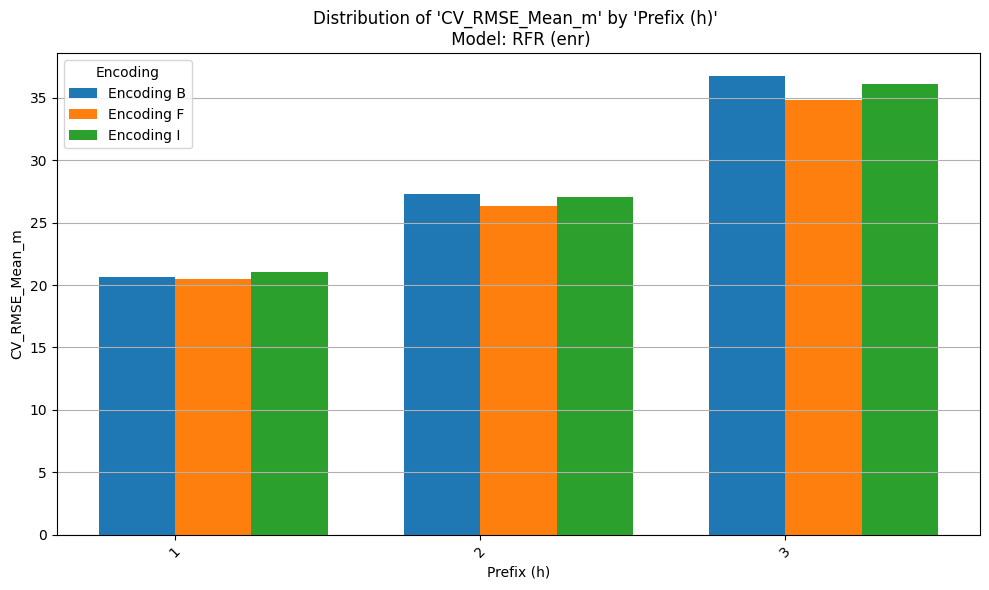

In [ ]:
if (len(df_ml_rfr) > 0):
    df_ml_rfr_enr = df_ml_rfr[df_ml_rfr["Type"] == enr_suffix]
    print(f"> Plotting RFR - ML results ({enr_suffix})")
    plot_custom_distribution_side_by_side(df_ml_rfr_enr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", f"RFR ({enr_suffix})", ht_str)

> Plotting XGR - ML results (std)


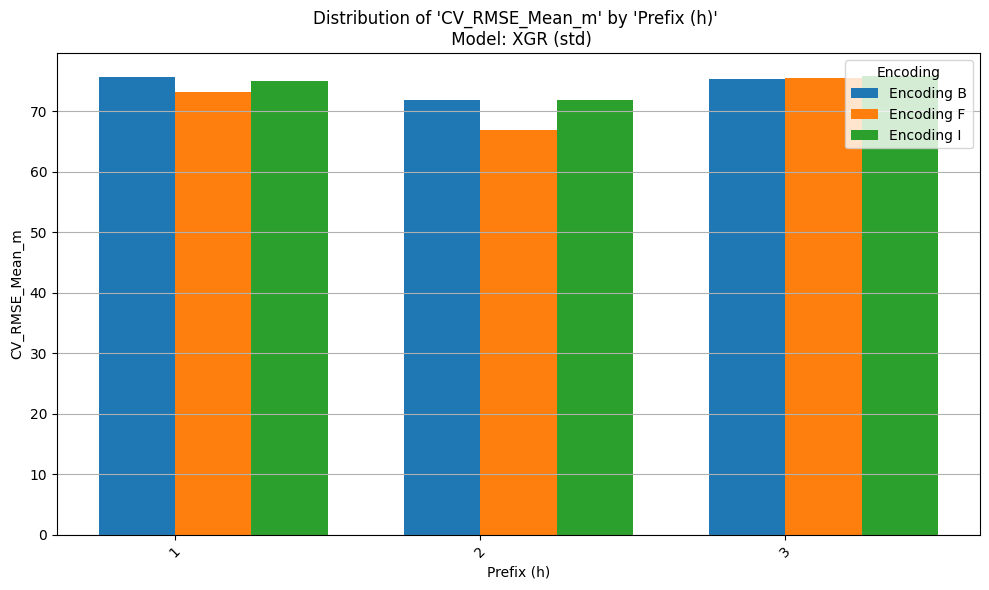

In [ ]:
if (len(df_ml_xgr) > 0):
    df_ml_xgr_std = df_ml_xgr[df_ml_xgr["Type"] == std_suffix]
    print(f"> Plotting XGR - ML results ({std_suffix})")
    plot_custom_distribution_side_by_side(df_ml_xgr_std, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", f"XGR ({std_suffix})", ht_str)

> Plotting XGR - ML results (enr)


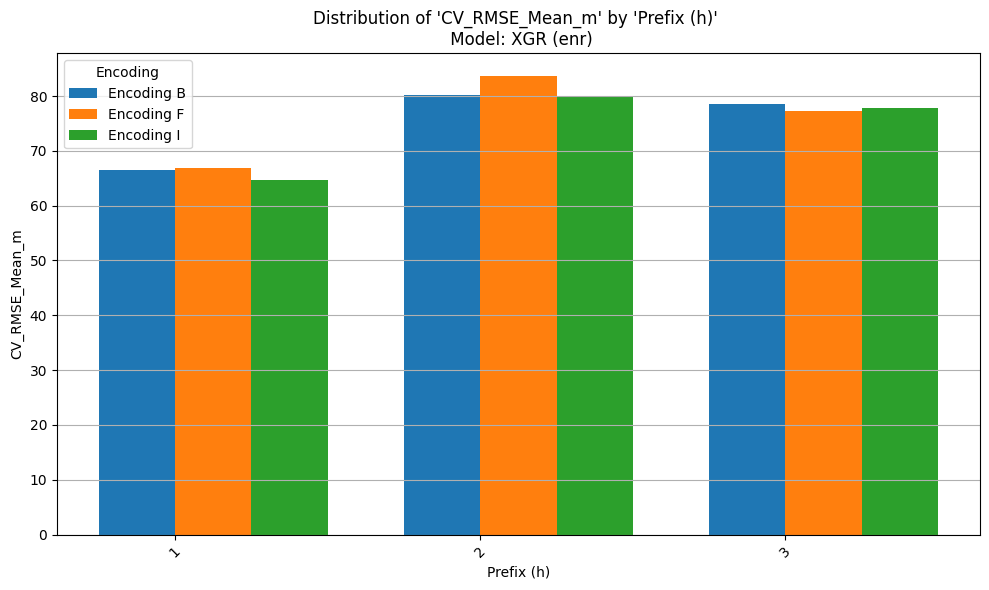

In [ ]:
if (len(df_ml_xgr) > 0):
    df_ml_xgr_enr = df_ml_xgr[df_ml_xgr["Type"] == enr_suffix]
    print(f"> Plotting XGR - ML results ({enr_suffix})")
    plot_custom_distribution_side_by_side(df_ml_xgr_enr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", f"XGR ({enr_suffix})", ht_str)

In [ ]:
print(">> Saving ML results for standard event log")

path_out = Path(ml_dir) / f"ML_results_{ht_str}_HT.csv"
print("File:", path_out)
df_ml.to_csv(path_out, sep=";", index=False)

path_out = Path(ml_dir) / f"ML_results_{ht_str}_HT.xlsx"
print("File:", path_out)
df_ml.to_excel(path_out, index=False, sheet_name=f"ML_results_{ht_str}_HT")

>> Saving ML results for standard event log
File: data_ml/ML_ensemble_results_RFR.csv
File: data_ml/ML_ensemble_results_RFR.xlsx


In [ ]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-06 11:33:48
Time to finish: 0:10:04

*** PROGRAM END ***

